You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import scipy

In [2]:
bm = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv')

In [3]:
bm.head(5)

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [4]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


In [5]:
#ctz has too many nulls. drop.

bm = bm.drop('ctz',axis=1)
bm = bm.drop(['name','bib'], axis=1)

In [6]:
bm = bm.drop(['country','state','city'], axis = 1)

In [7]:
# turn numeric columns into numeric

num = ['25k','10k','age','official','35k','overall','pace','30k','5k','half','20k','40k']
bm[num] = bm[num].apply(pd.to_numeric, errors = 'coerce', axis=1)
print(bm.dtypes)

25k          float64
age          float64
division       int64
10k          float64
gender        object
half         float64
official     float64
overall      float64
pace         float64
30k          float64
5k           float64
genderdiv      int64
20k          float64
35k          float64
40k          float64
dtype: object


In [8]:
#male and female
bm['gender_num']=bm['gender']
bm['gender_num']=bm['gender_num'].str.replace('M','0')
bm['gender_num']=bm['gender_num'].str.replace('F','1')
bm['gender_num']=pd.to_numeric(bm['gender_num'], errors='coerce')

In [9]:
bm = bm.drop(['gender'],axis=1)

In [10]:
bm.shape
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 15 columns):
25k           16141 non-null float64
age           16164 non-null float64
division      16164 non-null int64
10k           16138 non-null float64
half          16148 non-null float64
official      16164 non-null float64
overall       16164 non-null float64
pace          16164 non-null float64
30k           16147 non-null float64
5k            16098 non-null float64
genderdiv     16164 non-null int64
20k           16147 non-null float64
35k           16143 non-null float64
40k           16147 non-null float64
gender_num    16164 non-null int64
dtypes: float64(12), int64(3)
memory usage: 1.8 MB


In [11]:
bm.dropna(axis=0)
bm.head(1)

,25k,age,division,10k,half,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,gender_num
0,49.87,28.0,9,18.18,40.93,90.9,9.0,3.47,62.07,8.9,9,38.8,74.73,85.55,0


In [12]:
#linear interpolation is a method of
#curve fitting
bm.interpolate().count()

25k           16164
age           16164
division      16164
10k           16164
half          16164
official      16164
overall       16164
pace          16164
30k           16164
5k            16164
genderdiv     16164
20k           16164
35k           16164
40k           16164
gender_num    16164
dtype: int64

In [14]:
X = bm.iloc[:, :14]
y = bm.iloc[:, 14]
y = np.where(y>0,0,1)
print("y has {} values".format(len(y)))
print("X has {} values".format(len(X)))
# should I normalize y?



y has 16164 values
X has 16164 values


In [23]:
#normalize
X_norm = normalize(X.fillna(value = 0, axis=0))
print(len(X_norm))
X_pca = PCA(2).fit_transform(X_norm)

16164


In [24]:
# Split the data 
#into four equally-sized samples. First we break it in half:

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_norm, X_pca, 
                                                    test_size=0.5, 
                                                    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

In [25]:
#Verify for four sets
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

4041 4041
4041 4041
4041 4041
4041 4041


### K-Means

In [26]:
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

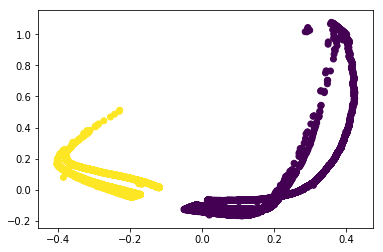

In [30]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()


In [28]:
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))
#overfitting?

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0         9  9680
1      6475     0


### Mean-Shift

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm,
    y,
    test_size=0.9,
    random_state=42)

In [40]:
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=2000)

In [41]:
# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)
# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


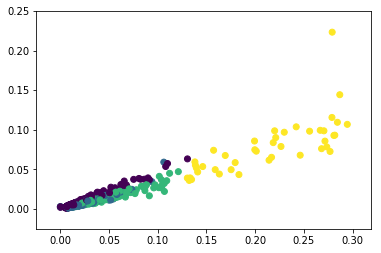

Comparing the assigned categories to the ones in the data:
col_0    0    1    2   3
row_0                   
0        0  642    0   2
1      690    0  242  40


In [42]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

### Spectral CLustering

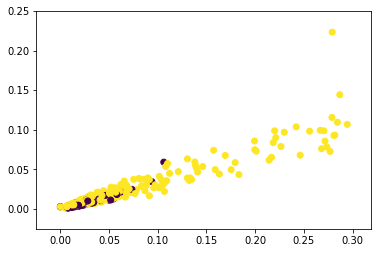

Comparing the assigned categories to the ones in the data:
col_0    0    1
row_0          
0      642    2
1        0  972


In [43]:
# We know we're looking for three clusters.
n_clusters=2

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))